In [1]:
import os
import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torchvision.datasets import ImageFolder
from PIL import Image

In [2]:
data_root = '/content/drive/MyDrive/컴퓨터비전 시즌2/5. 컴퓨터 비전/Data/5'

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
def display_images(image_paths, title, max_images=4):
    plt.figure(figsize=(12, 3))
    for i, image_path in enumerate(image_paths[:max_images]):
        img = plt.imread(image_path)
        plt.subplot(1, max_images, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.show()

In [5]:
categories = ['Train santa', 'Train normal', 'Val santa', 'Val normal', 'Test santa', 'Test normal']

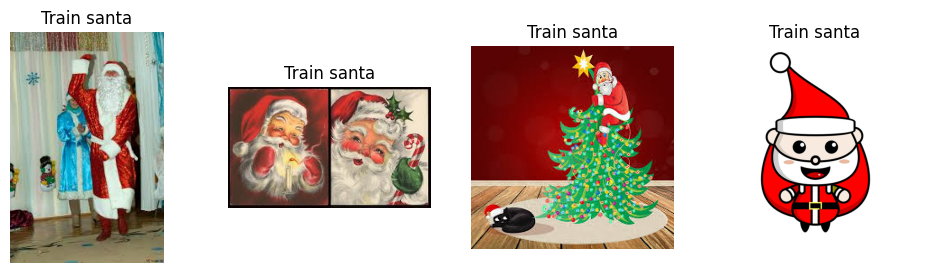

Train santa 총 이미지 수: 446


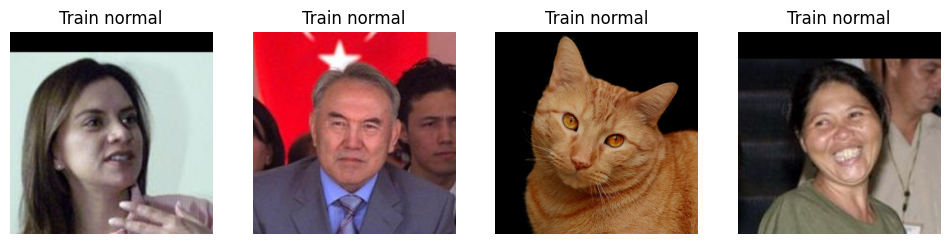

Train normal 총 이미지 수: 449


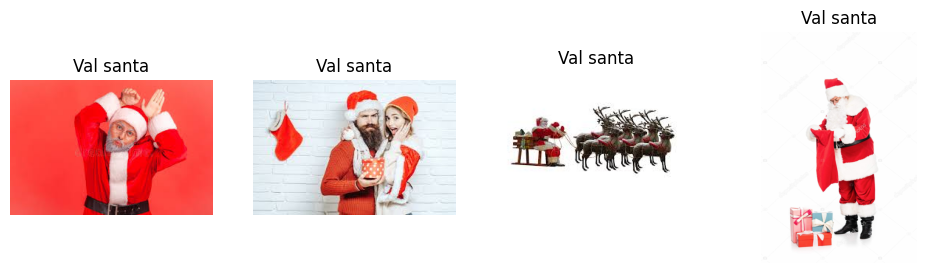

Val santa 총 이미지 수: 133


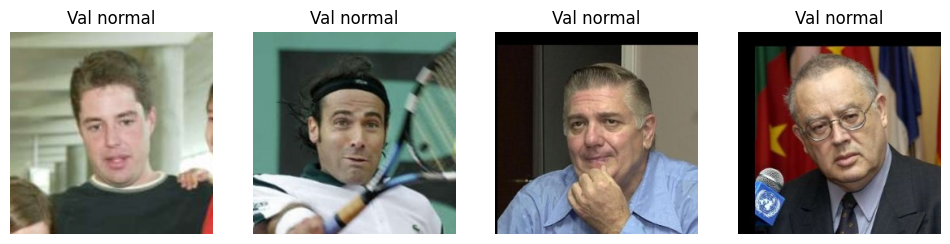

Val normal 총 이미지 수: 134


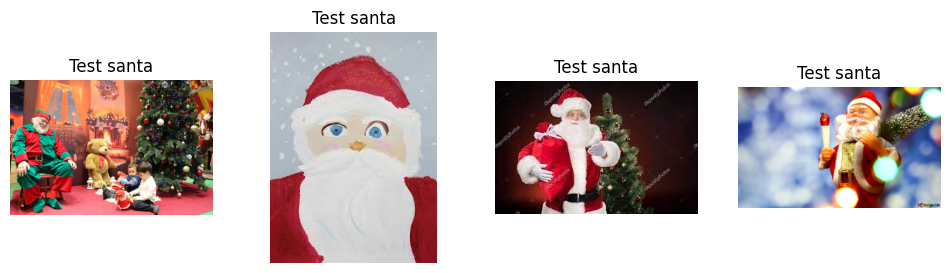

Test santa 총 이미지 수: 36


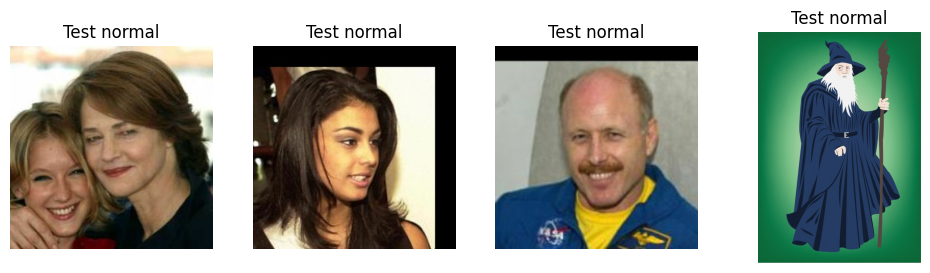

Test normal 총 이미지 수: 32


In [6]:
for category in categories:
    image_paths = glob.glob(f'{data_root}/{category.lower().replace(" ", "/")}/*')
    # print(image_paths)
    display_images(image_paths, category)
    print(f'{category} 총 이미지 수: {len(image_paths)}')

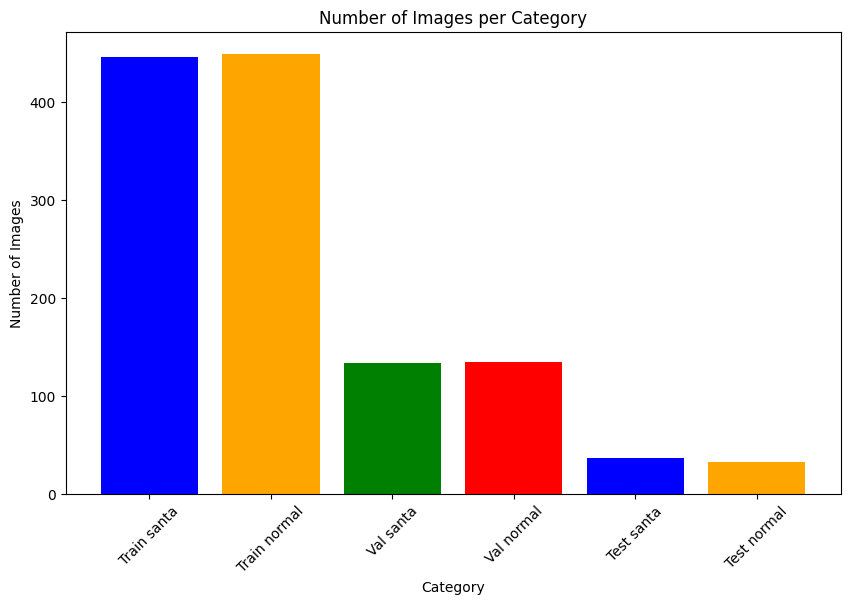

In [7]:
plt.figure(figsize=(10, 6))
plt.bar(categories, [len(glob.glob(f'{data_root}/{category.lower().replace(" ", "/")}/*')) for category in categories], color=['blue', 'orange', 'green', 'red'])
plt.title('Number of Images per Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.458, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
train_dataset = ImageFolder(f'{data_root}/train', transform=transform)
val_dataset = ImageFolder(f'{data_root}/val', transform=transform)

In [10]:
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16, shuffle=False)

In [11]:
class VGG19(nn.Module):
    def __init__(self, num_classes=1000):
        super(VGG19, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            # 메모리 절약, 입력 텐서의 원본 데이터가 변경
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [12]:
# 사전 학습된 VGG19 모델 불러오기
pretrained_vgg19 = models.vgg19(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 171MB/s]


In [13]:
model = VGG19(num_classes=1000)

In [14]:
# 사전 학습된 모델의 features 부분에서 가중치 추출
pretrained_keys = set(pretrained_vgg19.features.state_dict().keys())

In [15]:
# state_dict 키와 모델의 파라미터 이름이 일치하지 않으면 오류가 발생
# strict=False 설정하면 일부 파라미터가 다르더라도 일치하는 부분만 로드, 나머지는 무시
result = model.features.load_state_dict(pretrained_vgg19.features.state_dict(), strict=False)

In [16]:
# 복사 후 커스텀 모델의 features 부분에서 가중치 추출
custom_keys = set(model.features.state_dict().keys())

In [17]:
# 커스텀 모델과 사전 학습된 모델 모두에 존재하는 가중치
successfully_copied_keys = pretrained_keys.intersection(custom_keys)

In [18]:
# 커스텀 모델에는 있지만 사전 학습된 모델에 없는 가중치
missing_keys = custom_keys - pretrained_keys

In [19]:
# 사전 학습된 모델에는 있지만 커스텀 모델에 없는 가중치
unexpected_keys = pretrained_keys - custom_keys

In [20]:
print('successfully_copied_keys: ', successfully_copied_keys)
print('missing_keys: ', missing_keys)
print('unexpected_keys: ', unexpected_keys)

successfully_copied_keys:  {'23.weight', '28.weight', '23.bias', '32.weight', '19.weight', '16.bias', '10.bias', '5.weight', '0.bias', '21.bias', '2.bias', '12.bias', '14.weight', '19.bias', '12.weight', '34.bias', '14.bias', '34.weight', '10.weight', '28.bias', '5.bias', '0.weight', '25.weight', '2.weight', '7.bias', '21.weight', '30.weight', '25.bias', '16.weight', '7.weight', '32.bias', '30.bias'}
missing_keys:  set()
unexpected_keys:  set()


In [21]:
for param in model.features.parameters():
    param.requires_grad = False

In [23]:
model.classifier[6] = nn.Linear(4096, 1)

for param in model.classifier.parameters():
    param.requires_grad = True

In [24]:
model = model.to(device)
model

VGG19(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), pa

In [25]:
loss_func = nn.BCEWithLogitsLoss()

In [26]:
def validate_model(model, val_loader, loss_func):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)
            outputs = model(inputs)
            val_loss += loss_func(outputs, labels).item()
            predicted = torch.sigmoid(outputs) > 0.5
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    return val_loss, val_accuracy

In [31]:
def train_model(optim_name, model, train_loader, val_loader, loss_func, num_epochs=10):
    if optim_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    elif optim_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
    elif optim_name == 'RAdam':
        optimizer = optim.RAdam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
    else:
        raise ValueError(f'Unsupported optimizer: {optim_name}')

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        val_loss, val_accuracy = validate_model(model, val_loader, loss_func)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'[{optim_name}] Epoch {epoch + 1}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, Val Accuracy: {val_accuracy:.2f}%')

    return train_losses, val_losses, val_accuracies

In [32]:
train_losses_Adam, val_losses_Adam, val_accuracies_Adam = train_model(
    'Adam', model, train_loader, val_loader, loss_func
)

[Adam] Epoch 1, Train Loss: 1.102276, Val Loss: 0.250960, Val Accuracy: 94.38%
[Adam] Epoch 2, Train Loss: 1.244717, Val Loss: 0.248607, Val Accuracy: 94.38%
[Adam] Epoch 3, Train Loss: 0.370733, Val Loss: 0.848581, Val Accuracy: 90.26%
[Adam] Epoch 4, Train Loss: 0.582944, Val Loss: 0.722850, Val Accuracy: 93.26%
[Adam] Epoch 5, Train Loss: 0.580005, Val Loss: 0.419229, Val Accuracy: 95.51%
[Adam] Epoch 6, Train Loss: 0.575810, Val Loss: 0.610092, Val Accuracy: 91.76%
[Adam] Epoch 7, Train Loss: 0.376254, Val Loss: 0.488644, Val Accuracy: 94.01%
[Adam] Epoch 8, Train Loss: 0.095761, Val Loss: 0.309014, Val Accuracy: 96.63%
[Adam] Epoch 9, Train Loss: 0.415663, Val Loss: 0.266296, Val Accuracy: 96.25%
[Adam] Epoch 10, Train Loss: 0.123801, Val Loss: 1.019343, Val Accuracy: 93.26%


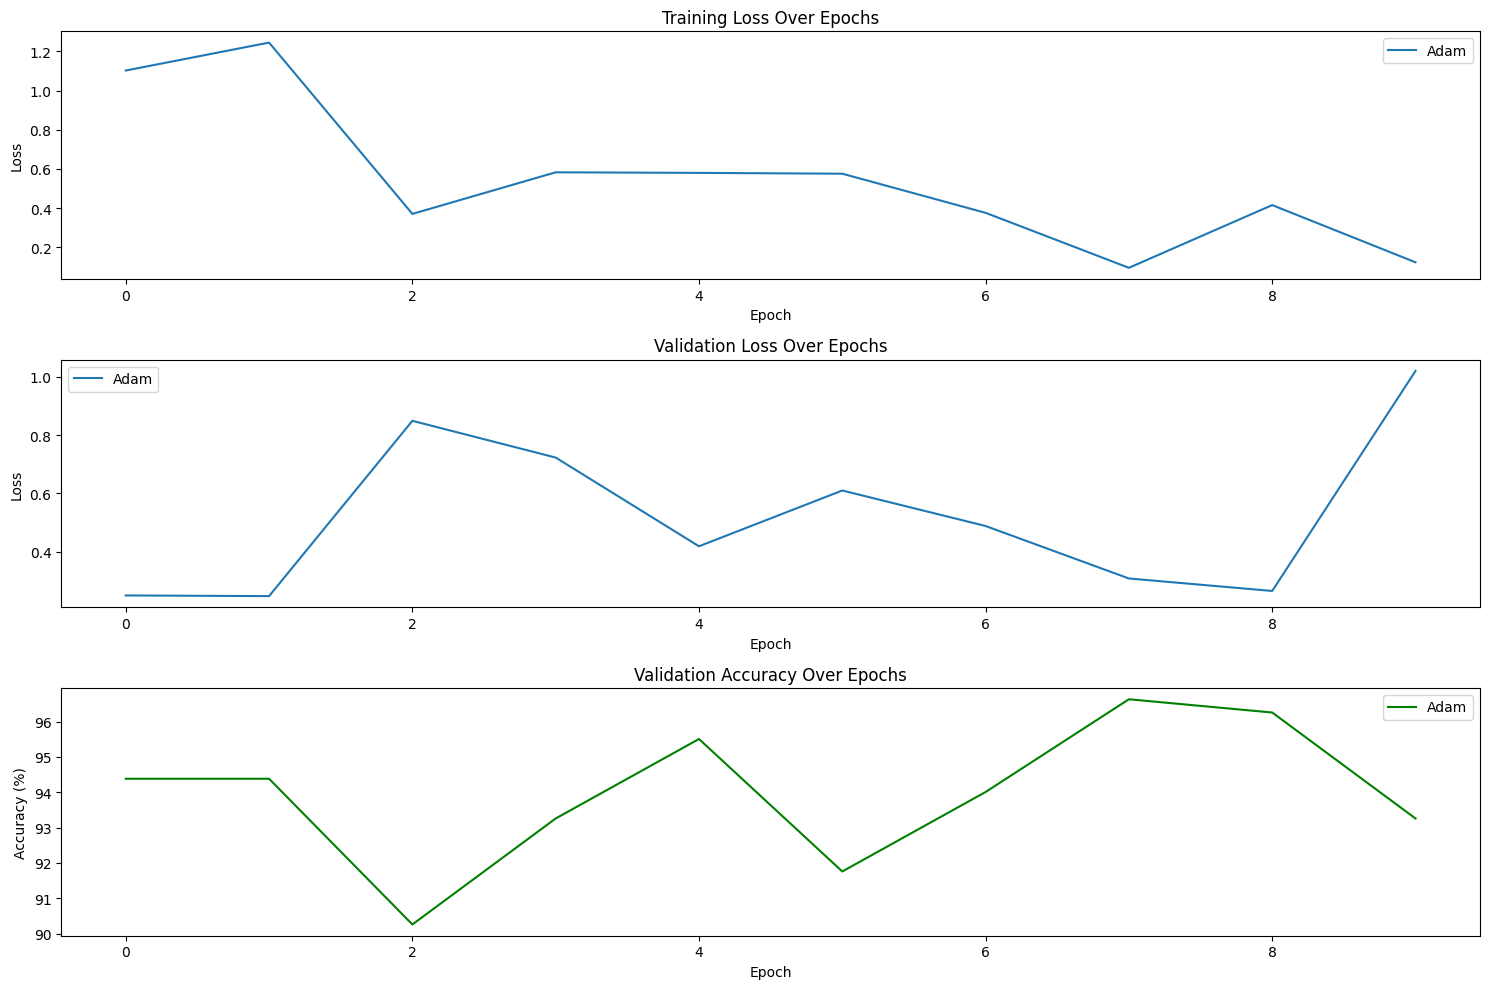

In [33]:
# 학습 손실과 검증 정확도 그래프 그리기
plt.figure(figsize=(15, 10))

# 학습 손실 그래프
plt.subplot(3, 1, 1)  # 3행 1열의 첫 번째 위치
plt.plot(train_losses_Adam, label='Adam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
# plt.ylim(0, 0.2)

# 검증 손실 그래프
plt.subplot(3, 1, 2)  # 3행 1열의 두 번째 위치
plt.plot(val_losses_Adam, label='Adam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()
# plt.ylim(0, 1.5)

# 검증 정확도 그래프
plt.subplot(3, 1, 3)  # 3행 1열의 세 번째 위치
plt.plot(val_accuracies_Adam, label='Adam', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
# plt.ylim(80, 100)

plt.tight_layout()
plt.show()

In [34]:
def load_and_transform_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0).to(device)

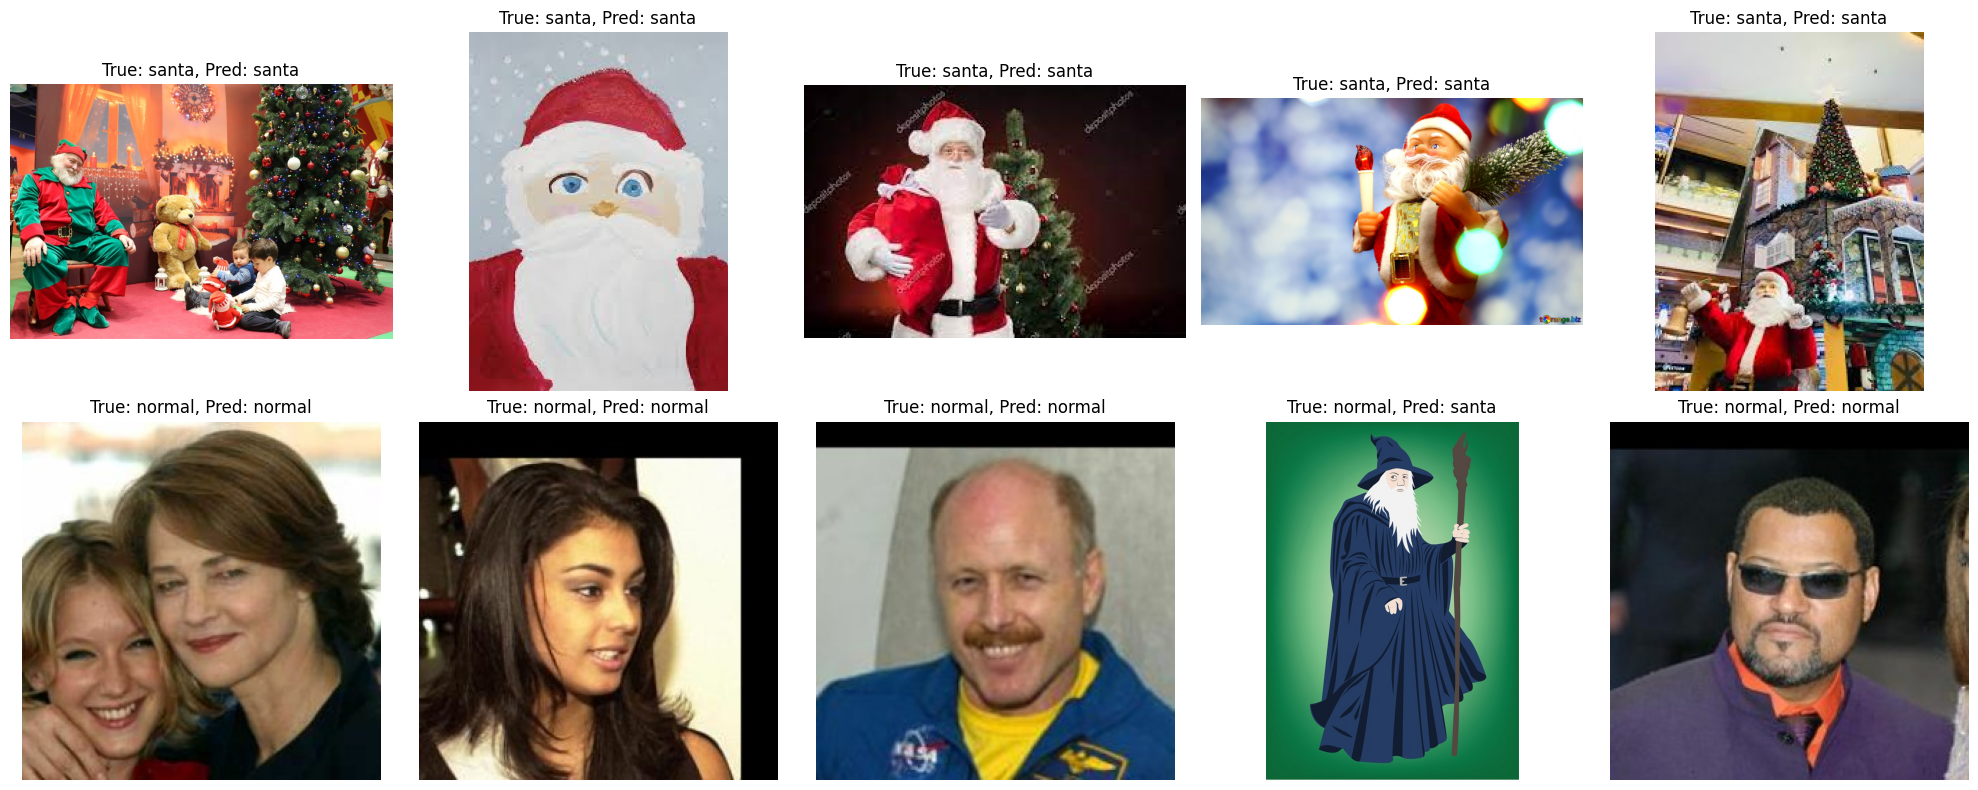

In [35]:
class_folders = {
    'santa': f'{data_root}/test/santa',
    'normal': f'{data_root}/test/normal'
}

plt.figure(figsize=(20, 8))

counter = 1

for class_name, folder_path in class_folders.items():
    image_paths = glob.glob(os.path.join(folder_path, "*"))
    selected_paths = image_paths[:5]

    for image_path in selected_paths:
        image = load_and_transform_image(image_path, transform)

        model.eval()
        with torch.no_grad():
            outputs = model(image)
            probs = torch.sigmoid(outputs).item()
            prediction = 'santa' if probs >= 0.5 else 'normal'

        plt.subplot(2, 5, counter)
        plt.imshow(Image.open(image_path))
        plt.title(f'True: {class_name}, Pred: {prediction}')
        plt.axis('off')

        counter += 1

plt.tight_layout()
plt.show()